In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [2]:
df = pd.read_excel("df_token_2.xlsx")

In [3]:
df.describe()

,num,price,interest,chat,view,reup
count,6.742100e+04,6.742100e+04,67421.000000,67421.000000,67421.000000,67421.000000
mean,2.097492e+08,5.895242e+04,2.918660,1.705166,220.787811,0.522612
std,5.751118e+07,3.885279e+06,4.833499,2.070392,257.325533,0.499492
min,1.000148e+08,0.000000e+00,-17.000000,0.000000,0.000000,0.000000
25%,1.644737e+08,1.000000e+04,0.000000,1.000000,84.000000,0.000000
50%,2.039104e+08,2.000000e+04,2.000000,1.000000,149.000000,1.000000
75%,2.671604e+08,3.100000e+04,4.000000,2.000000,265.000000,1.000000
max,2.930429e+08,1.000000e+09,460.000000,131.000000,10397.000000,1.000000


In [12]:
df2 = df[(df.interest > 0) & (df.view > 0)]
df = df[(df.interest >= 0) & (df.view >= 0)]

In [15]:
df.shape

(67286, 19)

In [46]:
len(df.cate_final.unique())

31

<AxesSubplot:xlabel='cate_final'>

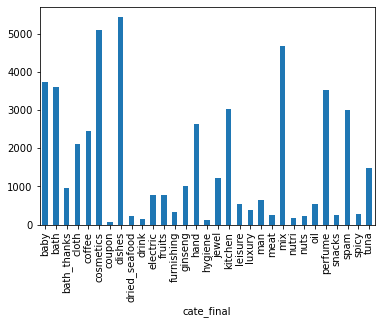

In [9]:
df2.groupby('cate_final').title.count().plot.bar()

<AxesSubplot:xlabel='cate_final'>

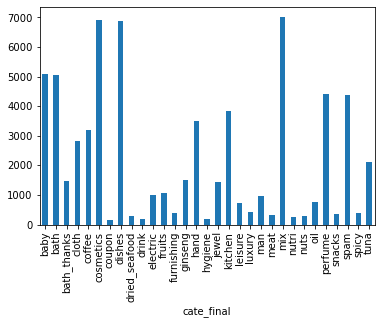

In [11]:
df3.groupby('cate_final').title.count().plot.bar()

In [5]:
df['log_view'] = np.log(df.view) + 0.000001
df['ratio'] = df.interest / df.view
df['log_interest'] = np.log(df.interest) + 0.000001
df['log_ratio'] = df.log_interest/df.log_view

In [6]:
df.describe()

,num,price,interest,chat,view,reup,log_view,ratio,log_interest,log_ratio
count,6.176600e+04,6.176600e+04,61766.000000,61766.000000,61766.000000,61766.000000,61766.000000,61766.000000,61766.000000,6.176600e+04
mean,2.118522e+08,5.016857e+04,3.921235,1.818476,256.536509,0.600087,5.199420,0.019159,0.967552,1.758355e-01
std,5.740325e+07,4.184468e+05,5.116387,2.281936,282.996200,0.489884,0.819631,0.016301,0.839184,1.428877e-01
min,1.000148e+08,0.000000e+00,1.000000,0.000000,3.000000,0.000000,1.098613,0.000648,0.000001,1.362122e-07
25%,1.669561e+08,1.100000e+04,1.000000,1.000000,105.000000,0.000000,4.653961,0.008772,0.000001,2.452460e-07
50%,2.079195e+08,2.000000e+04,2.000000,1.000000,179.000000,1.000000,5.187387,0.014634,0.693148,1.729699e-01
75%,2.696696e+08,3.500000e+04,5.000000,2.000000,309.000000,1.000000,5.733342,0.024194,1.609439,2.848044e-01
max,2.930429e+08,7.000000e+07,460.000000,131.000000,10397.000000,1.000000,9.249274,0.333333,6.131227,6.642119e-01


# 사용할 변수들 : interest, view, ratio

In [13]:
from tokenizers import CharBPETokenizer
from sklearn.feature_extraction.text import CountVectorizer

with open ('weight.txt', 'w', encoding='utf8') as f:
    for row in df.itertuples():
        f.write(row.title)
        f.write('\n')

bpe = CharBPETokenizer(lowercase=True)
bpe.train(files='weight.txt', min_frequency=5, vocab_size=50000)

def tokenizer(text):
    enc = bpe.encode(text)
    for token in enc.tokens:
        token = token.replace('</w>', '')
        if len(token) > 1:
            yield token
            
cv = CountVectorizer(max_features=500, tokenizer=tokenizer)
dtm = cv.fit_transform(df.title)

In [14]:
cv = CountVectorizer(max_features=500, tokenizer=tokenizer)
dtm = cv.fit_transform(df.title)



,단어,빈도
237,선물세트,19765
246,세트,14303
228,새상품,12004
229,새제품,5087
175,미개봉,4384
...,...,...
120,도마,97
177,미개봉새제품,97
147,리엔,97
203,버베나,96


In [ ]:
wc = pd.DataFrame({'단어': cv.get_feature_names(), '빈도':dtm.sum(axis=0).flat})
wc.sort_values('빈도', ascending=False)

In [36]:
class Weight:
    
    def __init__(self, yy, avg):
        self.yy = yy 
        self.avg = avg
        
    
    def weight_continue(self):
        x = dtm
        y = self.yy

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(1)
        ])

        model.compile(loss='mse', metrics=['mae'])

      
        model.fit(x.A, y, epochs=10, validation_split=0.1)

        weight = model.weights[0].numpy() # 단어별 가중치
        word_weight = pd.DataFrame({
            '단어' : cv.get_feature_names(),
            '가중치' : weight.flat
        })
    
        return word_weight



    def weight_categorical(self):
        x = dtm
        y = np.where(self.yy > self.avg, 1, 0) # 범주형 

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        model.compile(loss='binary_crossentropy', 
                      metrics=['accuracy'])

        model.fit(x.A, y, epochs=10, validation_split=0.1, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience = 1)])

        weight = model.weights[0].numpy() # 단어별 가중치
        word_weight = pd.DataFrame({
            '단어' : cv.get_feature_names(),
            '가중치' : weight.flat
        })

        return word_weight
    


## interest 

In [37]:
yy = df.interest
avg = yy.mean()
a = Weight(yy, avg)

# a1 = a.weight_continue()
a2 = a.weight_categorical()

Epoch 1/10
1893/1893 [==============================] - 2s 762us/step - loss: 0.6570 - accuracy: 0.6255 - val_loss: 0.6309 - val_accuracy: 0.6698
Epoch 2/10
1893/1893 [==============================] - 1s 601us/step - loss: 0.6457 - accuracy: 0.6368 - val_loss: 0.6282 - val_accuracy: 0.6726
Epoch 3/10
1893/1893 [==============================] - 1s 592us/step - loss: 0.6431 - accuracy: 0.6405 - val_loss: 0.6287 - val_accuracy: 0.6692


In [38]:
a1.sort_values('가중치', ascending=False)

,단어,가중치
231,샤넬,1.256506
307,에르메스,0.894984
367,정품,0.868477
156,마지막,0.823502
219,빈티지,0.742031
...,...,...
368,젖병,-1.590386
292,아모레퍼시픽,-1.593637
70,lg생활건강,-1.621247
99,기프티콘,-1.780763


In [39]:
a2.sort_values('가중치', ascending=False).to_excel('weight_interest2.xlsx')

## ratio

In [21]:
yy = df.ratio
avg = yy.mean()
c = Weight(yy, avg)

c1 = c.weight_continue()
c2 = c.weight_categorical()

Epoch 1/10
1738/1738 [==============================] - 1s 608us/step - loss: 0.0010 - mae: 0.0192 - val_loss: 3.0065e-04 - val_mae: 0.0137
Epoch 2/10
1738/1738 [==============================] - 1s 504us/step - loss: 2.8668e-04 - mae: 0.0118 - val_loss: 2.6374e-04 - val_mae: 0.0114
Epoch 3/10
1738/1738 [==============================] - 1s 520us/step - loss: 2.8627e-04 - mae: 0.0118 - val_loss: 2.5872e-04 - val_mae: 0.0113
Epoch 4/10
1738/1738 [==============================] - 1s 528us/step - loss: 2.8686e-04 - mae: 0.0118 - val_loss: 2.5823e-04 - val_mae: 0.0110
Epoch 5/10
1738/1738 [==============================] - 1s 624us/step - loss: 2.8777e-04 - mae: 0.0118 - val_loss: 2.6159e-04 - val_mae: 0.0115
Epoch 6/10
1738/1738 [==============================] - 1s 700us/step - loss: 2.8639e-04 - mae: 0.0118 - val_loss: 2.6318e-04 - val_mae: 0.0112
Epoch 7/10
1738/1738 [==============================] - 1s 622us/step - loss: 2.8639e-04 - mae: 0.0118 - val_loss: 2.7711e-04 - val_mae: 0.0

In [23]:
c1.sort_values('가중치', ascending=False)

,단어,가중치
481,핸드,0.017363
455,퍼퓸,0.010513
313,에스티로더,0.010474
422,크림,0.010039
32,2인조,0.009167
...,...,...
302,암웨이,-0.012982
117,글라스,-0.013748
473,한과,-0.014010
343,의자,-0.015207


In [24]:
c2.sort_values('가중치', ascending=False)

,단어,가중치
225,브러쉬,1.089260
430,탬버린즈,0.986854
455,퍼퓸,0.831062
404,캐스키드슨,0.769947
38,30포,0.750828
...,...,...
411,커피잔세트,-1.926731
270,수저세트,-2.080532
291,식용유,-2.126174
458,포트메리온,-2.177133


## view

In [40]:
yy = df.view
avg = yy.mean()
d = Weight(yy, avg)

# d1 = d.weight_continue()
d2 = d.weight_categorical()

Epoch 1/10
1893/1893 [==============================] - 2s 650us/step - loss: 0.6216 - accuracy: 0.6743 - val_loss: 0.5935 - val_accuracy: 0.7013
Epoch 2/10
1893/1893 [==============================] - 1s 604us/step - loss: 0.5960 - accuracy: 0.6864 - val_loss: 0.5852 - val_accuracy: 0.7093
Epoch 3/10
1893/1893 [==============================] - 1s 615us/step - loss: 0.5896 - accuracy: 0.6957 - val_loss: 0.5849 - val_accuracy: 0.7138
Epoch 4/10
1893/1893 [==============================] - 1s 593us/step - loss: 0.5889 - accuracy: 0.6989 - val_loss: 0.5867 - val_accuracy: 0.7138


In [41]:
d1.sort_values('가중치', ascending=False)

,단어,가중치
237,선물세트,17.118286
246,세트,16.156969
228,새상품,15.630583
229,새제품,12.988146
270,스팸,12.830770
...,...,...
157,만원,1.846127
203,버베나,1.842203
168,모빌,1.797119
101,꼬달리,1.786491


In [42]:
d2.sort_values('가중치', ascending=False)

,단어,가중치
455,포트메리온,1.193139
86,골프채,0.810569
142,로얄알버트,0.699362
407,커피잔,0.692622
74,가격내림,0.646319
...,...,...
350,임산부,-1.088028
412,케어,-1.105048
263,스킨케어,-1.107634
204,버츠비,-1.317683


In [43]:
d2.sort_values('가중치', ascending=False).to_excel('weight_view2.xlsx')